# Time Series Project : Forecasting Amazon Stock Prices

Forecasting stock prices is a crucial yet challenging task in financial analysis due to the inherently volatile and non-stationary nature of stock market data. In this project, we aim to predict the stock closing price of Amazon Inc. using classical time series models — specifically, ARIMA (AutoRegressive Integrated Moving Average) and ARIMAX (ARIMA with exogenous variables).

The novelty of this work lies in the incorporation of Google Trends data as an external predictor in the ARIMAX model. Google Trends provides insights into the volume of public interest in “Amazon” over time. This can serve as a proxy for investor sentiment or consumer attention, which often correlates with stock price movements.

The analysis begins with data preprocessing and exploratory analysis. The Amazon stock closing price is made stationary using differencing, and the optimal ARIMA model parameters are selected using ACF, PACF plots. The ARIMAX model is then constructed using Google Trends as an exogenous regressor to investigate whether incorporating public interest data improves forecasting performance.

By comparing the performance of ARIMA and ARIMAX models — particularly in terms of forecast accuracy metrics like Mean Squared Error (MSE) — the project assesses the effectiveness of including exogenous variables in traditional time series forecasting.

In [4]:
import pandas as pd
import numpy as np
import statsmodels as stats
import matplotlib.pyplot as plt
import seaborn as sns


## Getting the data

The project utilizes two primary datasets:

1. **Amazon Stock Price Data**  
   - Source: [Kaggle](https://www.kaggle.com/datasets/aenes95/amazon-stock-price-prediction)
   - Content: Daily OHLC (Open, High, Low, Close) prices, Volume, etc.  
   - Period: 2005 to recent

2. **Google Trends Data**  
   - Source: [Google Trends](https://trends.google.com)  
   - Search term: "Amazon"  
   - Content: Daily interest over time (values scaled from 0 to 100)



In [5]:
df1 = pd.read_csv("amazon_trends.csv")
df2 = pd.read_csv("mydata.csv")

In [6]:
df1.head()

,Date,Google_Trends
0,2005-01-01,37
1,2005-01-02,68
2,2005-01-03,56
3,2005-01-04,82
4,2005-01-05,42


In [7]:
df2.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Gain,Loss,...,Usd_Rub_Close,Usd_Try_Close,IRX_Close,JPM_Close,BAC_Close,Citigroup_Close,WFC_Close,NASDAQ_Close,SP_500_Close,Dow_Jones_Close
0,2005-01-03,44.95,45.44,44.21,44.52,10446500,0,0.0,0.23,0.00,...,27.71,1.3440,2.204,26.45,34.03,440.71,19.30,2152.149902,1202.079956,10729.429688
1,2005-01-04,42.67,43.26,41.50,42.14,19418500,0,0.0,0.00,2.38,...,27.71,1.3510,2.292,26.18,33.56,436.96,19.31,2107.860107,1188.050049,10630.780273
2,2005-01-05,41.57,42.76,41.56,41.77,8354200,0,0.0,0.00,0.37,...,27.86,1.3740,2.282,26.24,33.17,442.44,19.33,2091.239990,1183.739990,10597.830078
3,2005-01-06,41.81,42.25,40.90,41.05,8700900,0,0.0,0.00,0.72,...,27.77,1.3925,2.267,26.39,33.12,446.73,19.40,2090.000000,1187.890015,10622.879883
4,2005-01-07,41.38,42.69,41.16,42.32,9836600,0,0.0,1.27,0.00,...,27.75,1.3940,2.277,26.17,32.76,444.17,19.38,2088.610107,1186.189941,10603.959961


In [8]:
df2.shape

(3552, 36)

In [9]:
df2.isna().sum()

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
Dividends          0
Stock Splits       0
Gain               0
Loss               0
Avg_Gain           0
Avg_Loss           0
RSI                0
SMA                0
EMA                0
MACD               0
Bollinger_Upper    0
Bollinger_Lower    0
ROC                0
PVT                0
Usd_Eur_Close      0
Usd_Chf_Close      0
Usd_Gbp_Close      0
Usd_Jpy_Close      0
Usd_Cad_Close      0
Usd_Inf_Close      0
Usd_Rub_Close      0
Usd_Try_Close      0
IRX_Close          0
JPM_Close          0
BAC_Close          0
Citigroup_Close    0
WFC_Close          0
NASDAQ_Close       0
SP_500_Close       0
Dow_Jones_Close    0
dtype: int64

In [10]:
df1.isna().sum()

Date             0
Google_Trends    0
dtype: int64

<Axes: >

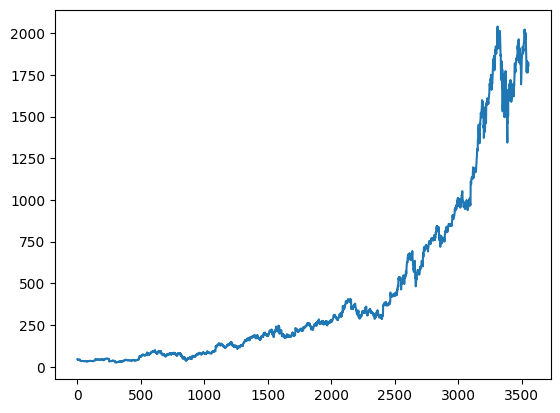

In [11]:
df2.Close.plot()

<Axes: >

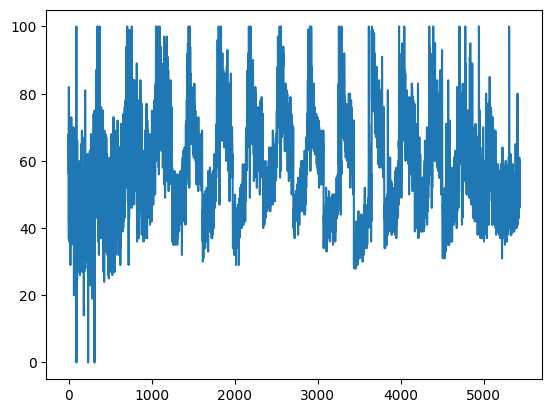

In [12]:
df1.Google_Trends.plot()

In [13]:
import scipy.stats as stats

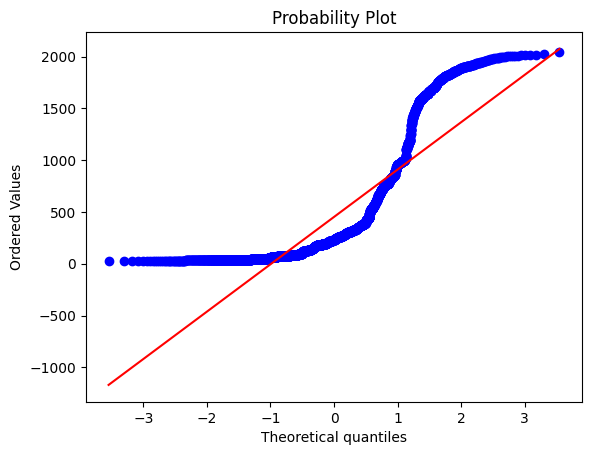

In [14]:
stats.probplot(df2.Close, dist = "norm", plot = plt)
plt.show()

## Data Preprocessing

In [151]:
data = pd.DataFrame(np.array(df2.Close))

In [152]:
#Setting date as index
data.set_index(df2.Date, inplace= True)

In [153]:
data.columns = ["Close"]

In [154]:
#fixing date type
data.index = pd.to_datetime(data.index, yearfirst= True)

In [155]:
#making the data frequency type according to business days
data = data.asfreq("b")

In [156]:
#handling missing values
data = data.ffill()

In [157]:
data.isna().sum()

Close    0
dtype: int64

## Checking for White noise

In [22]:
wn = np.random.normal(loc= data.Close.mean(), scale = data.Close.std(), size = len(data))
wn

array([1142.24928497, 1184.06536232,  623.10557428, ...,  125.13434565,
        426.69910171, 1514.33336383], shape=(3819,))

In [23]:
data["wn"] = wn

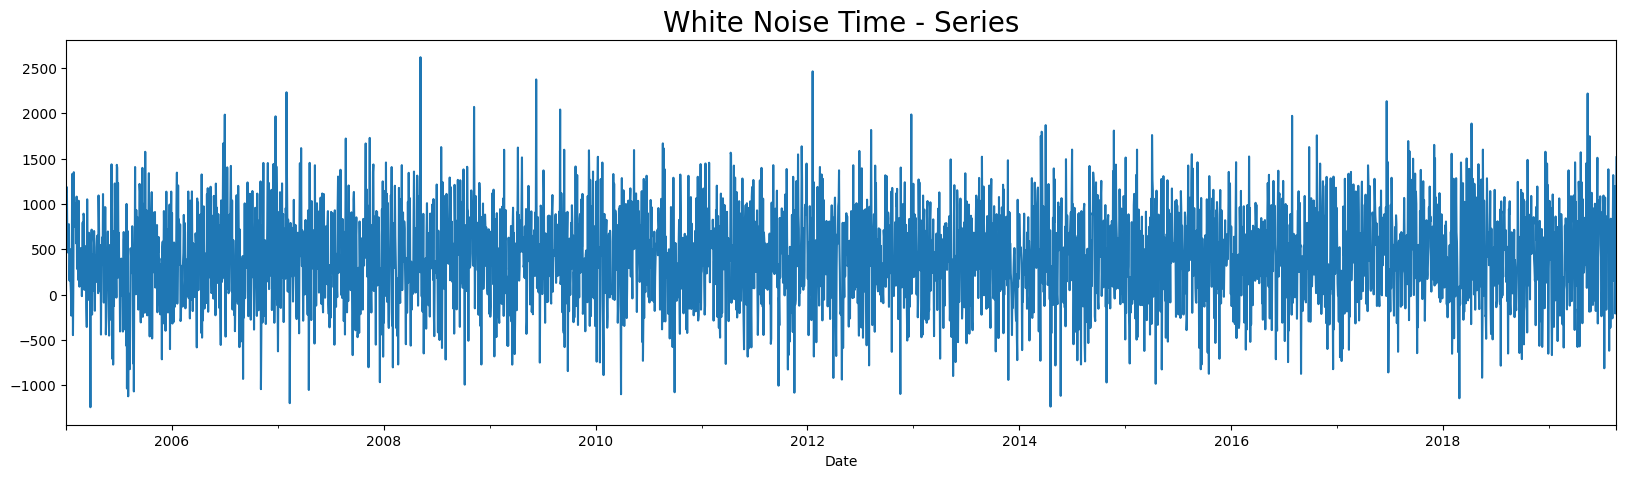

In [24]:
data.wn.plot(figsize = (20,5))
plt.title("White Noise Time - Series", size = 20)
plt. show()

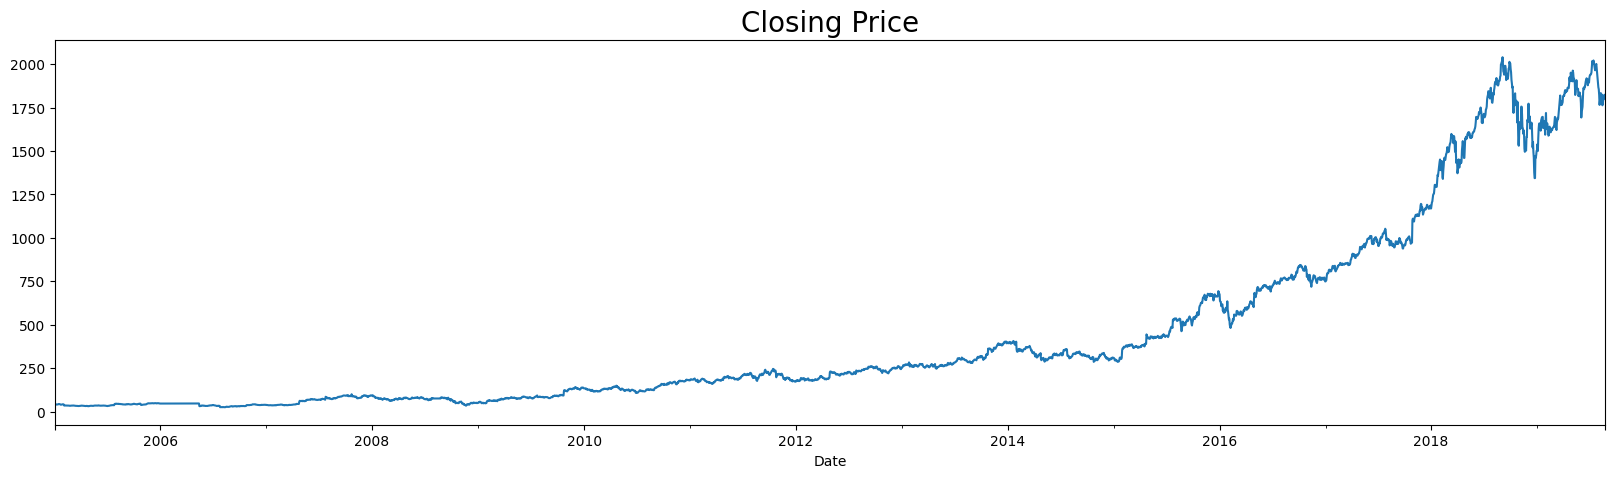

In [25]:
data.Close.plot(figsize = (20,5))
plt.title("Closing Price", size = 20)
plt. show()

In [26]:
import statsmodels.graphics.tsaplots as stg

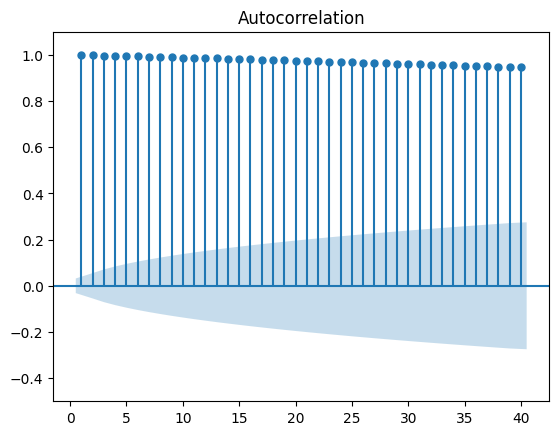

In [143]:
stg.plot_acf(data.Close,lags = 40, zero = False)
plt.ylim(-0.5,1.1)
plt.show()

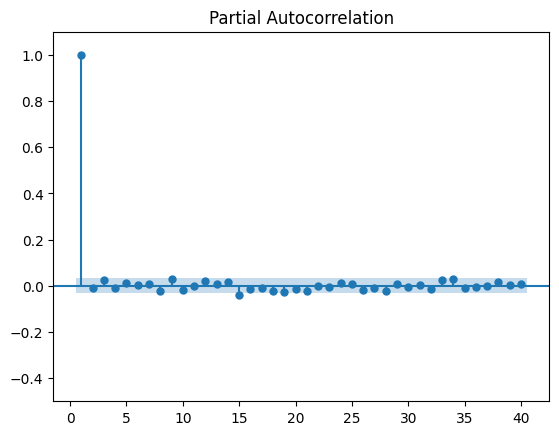

In [144]:
stg.plot_pacf(data.Close,lags = 40, zero = False)
plt.ylim(-0.5,1.1)
plt.show()

## Checking and handling for non-stationarity

In [28]:
from statsmodels.tsa.stattools import adfuller

In [29]:
result = adfuller(data.Close)
result

(np.float64(1.5753166457619365),
 np.float64(0.9977816013846071),
 29,
 3789,
 {'1%': np.float64(-3.432077035029176),
  '5%': np.float64(-2.8623031090615503),
  '10%': np.float64(-2.56717621307906)},
 np.float64(29885.67147604185))

Non stataionary since p-value > 0.05

In [30]:
#remoing trend and seasonality with the help of difference method
new_data = pd.DataFrame(data.Close.diff().dropna())

In [31]:

new_data.head()

,Close
Date,
2005-01-04,-2.38
2005-01-05,-0.37
2005-01-06,-0.72
2005-01-07,1.27
2005-01-10,-0.48


In [32]:
result_new = adfuller(new_data)
result_new

(np.float64(-10.82169019231105),
 np.float64(1.7988507555926574e-19),
 28,
 3789,
 {'1%': np.float64(-3.432077035029176),
  '5%': np.float64(-2.8623031090615503),
  '10%': np.float64(-2.56717621307906)},
 np.float64(29879.29603181051))

Stationary

<Axes: xlabel='Date'>

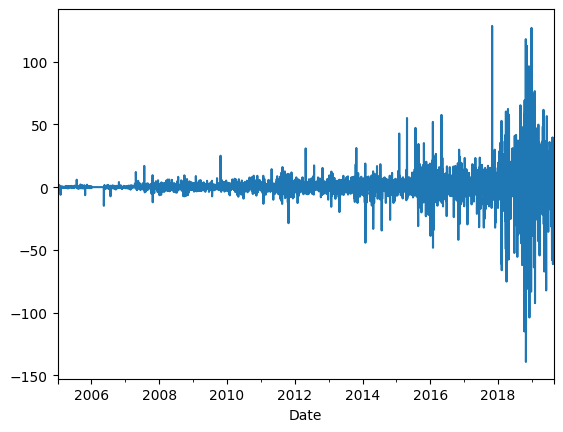

In [33]:
new_data.Close.plot()

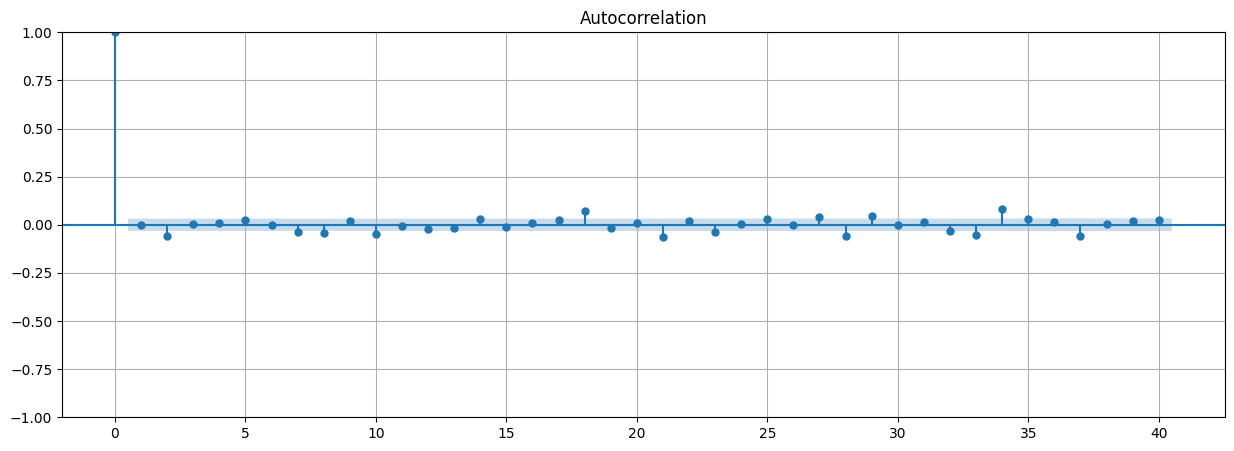

In [34]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(15, 5))
plot_acf(new_data.Close, lags=40, ax=plt.gca())

plt.grid(True)
plt.show()

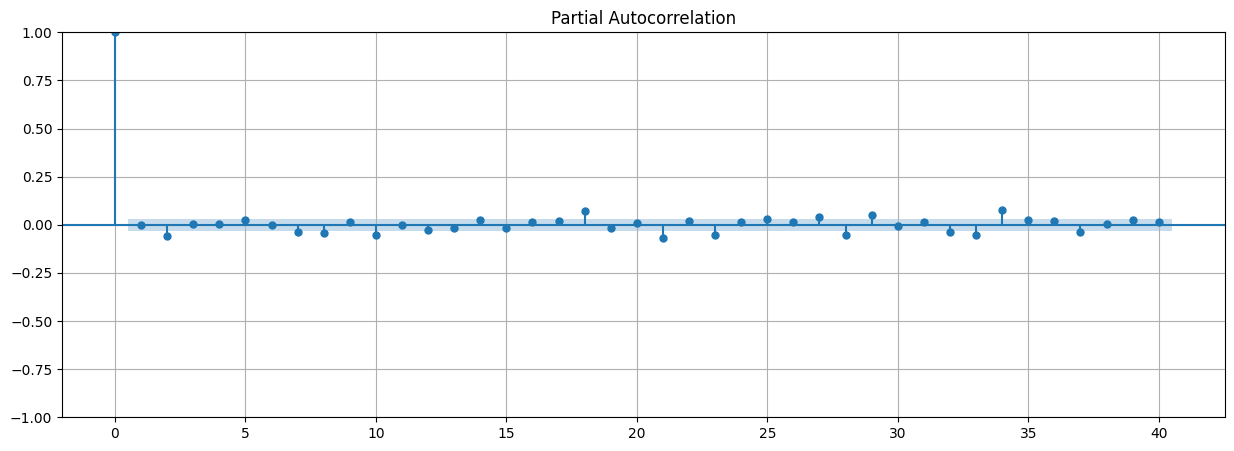

In [35]:
plt.figure(figsize=(15, 5))
plot_pacf(new_data.Close, lags=40, ax =plt.gca())

plt.grid(True)
plt.show()

From the upper analysis we get the ARIMA parameter value as p ==1, q==1, d ==1

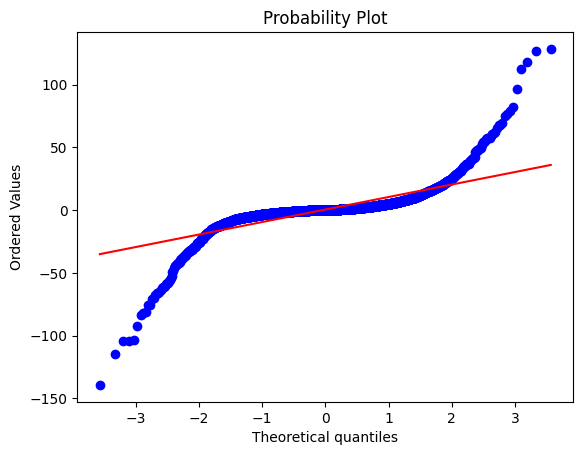

In [36]:
stats.probplot(new_data.Close, dist = "norm", plot = plt)
plt.show()

We see that

🔹 The original data is non-stationary (ADF p > 0.05)

🔹 After first differencing (d = 1), it becomes stationary, but the ACF and PACF plots are flat (i.e., no significant spikes)

i.e The differencing removed trend, and now the series is stationary
but there’s no strong autocorrelation structure left — the series behaves almost like white noise.

## Train Test Split of Data

we first add exogenous variable to our data for better modeling later on.

In [37]:
df1.Date = pd.to_datetime(df1.Date, yearfirst= True)

In [38]:
df1.set_index(df1.Date, inplace= True)
del df1['Date']

In [39]:
exo_data = df1.asfreq("b")

In [40]:
new_data["Google_trends"] = exo_data["Google_Trends"]

In [41]:
new_data["Actual Close"] = data.Close[1:]

In [42]:
new_data.columns = ["Diff_Close", "Google_trends", "Actual_Close"]
new_data.head()      

,Diff_Close,Google_trends,Actual_Close
Date,,,
2005-01-04,-2.38,82,42.14
2005-01-05,-0.37,42,41.77
2005-01-06,-0.72,61,41.05
2005-01-07,1.27,36,42.32
2005-01-10,-0.48,53,41.84


`Google_trends` is our exogenous variable

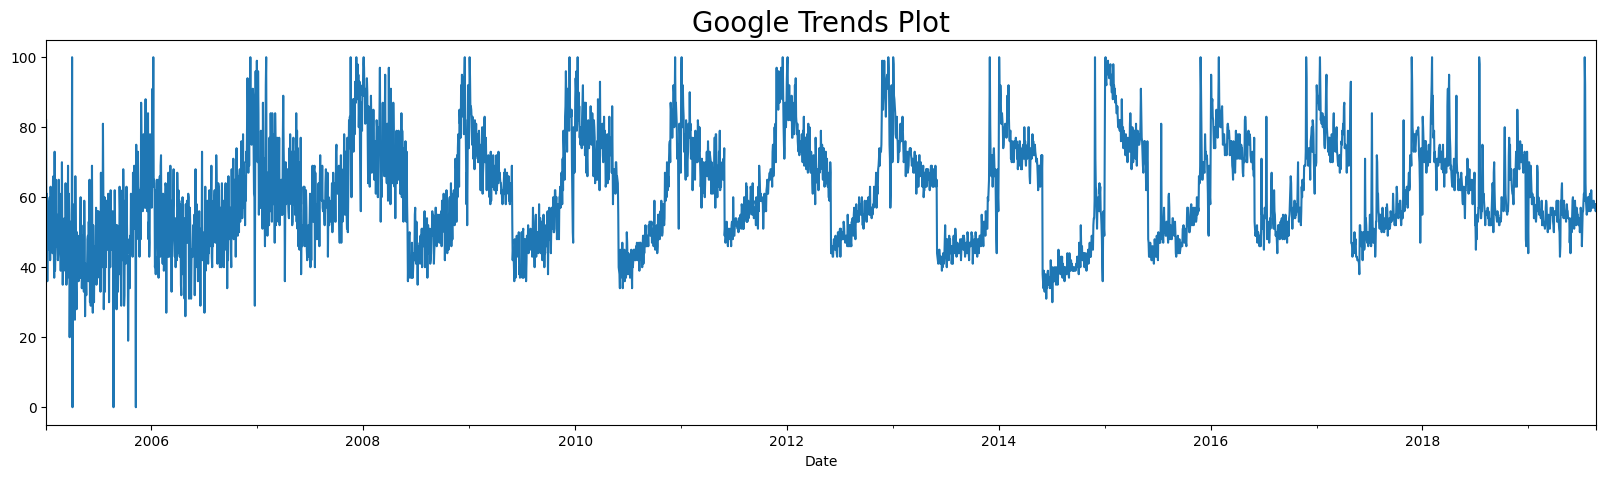

In [43]:
new_data.Google_trends.plot(figsize = (20,5))
plt.title("Google Trends Plot", size = 20)
plt.show()

In [44]:
size = int(len(new_data)*0.7)
train_data = new_data.iloc[:size, ]
test_data = new_data.iloc[size: , ]

In [45]:
train_data.tail()

,Diff_Close,Google_trends,Actual_Close
Date,,,
2015-03-26,-3.61,75,367.35
2015-03-27,3.21,73,370.56
2015-03-30,4.03,81,374.59
2015-03-31,-2.49,84,372.10
2015-04-01,-1.84,81,370.26


In [46]:
test_data.head()

,Diff_Close,Google_trends,Actual_Close
Date,,,
2015-04-02,1.99,76,372.25
2015-04-03,0.00,68,372.25
2015-04-06,4.79,73,377.04
2015-04-07,-2.63,80,374.41
2015-04-08,6.79,79,381.20


In [47]:
train_data.describe()

,Diff_Close,Google_trends,Actual_Close
count,2672.000000,2672.000000,2672.000000
mean,0.121909,60.868263,153.949847
std,3.858851,15.800109,108.125458
min,-44.320000,0.000000,26.070000
25%,-1.210000,48.000000,55.222500
50%,0.000000,60.000000,124.760000
75%,1.342500,72.000000,238.240000
max,42.750000,100.000000,407.050000


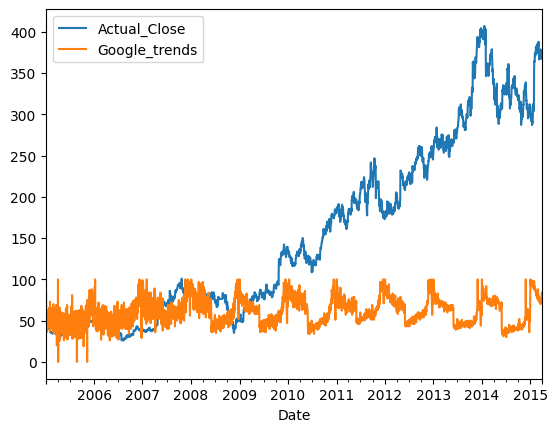

In [146]:
train_data[["Actual_Close", "Google_trends"]].plot()
plt.show()

## Checking for seasonality

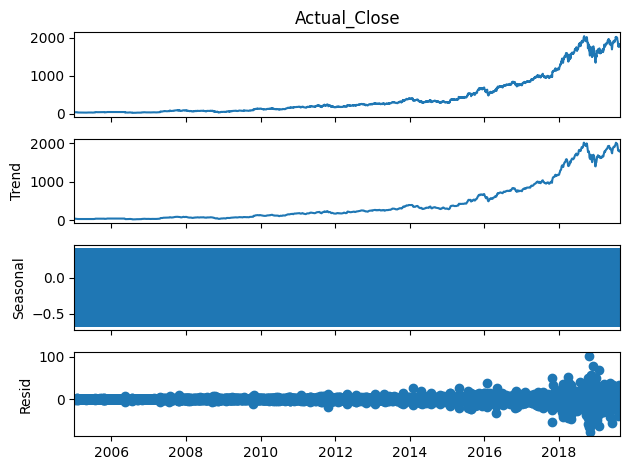

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
s_dec_additive = seasonal_decompose(new_data.Actual_Close, model = "additive")
s_dec_additive.plot()
plt.show()

The trend part is similar to the plot of Close as the trend uses previous data to predict future data. The seasonality part oscilates between -0.5 to 1 without any clear pattern. Hence no seasonality present. Lets cross check with multiplicative model.

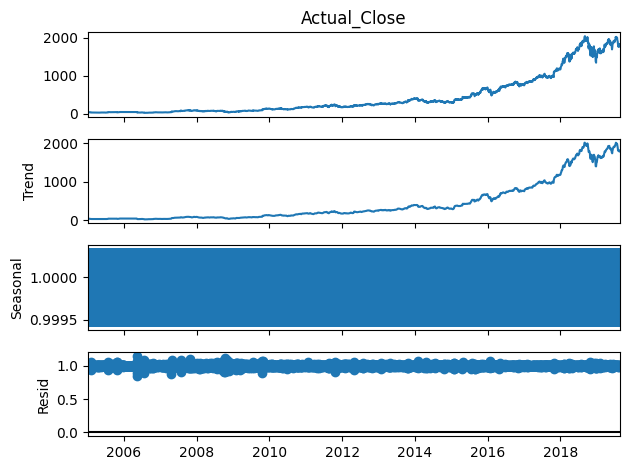

In [50]:
s_dec_multiplicative = seasonal_decompose(new_data.Actual_Close, model = "multiplicative")
s_dec_multiplicative.plot()
plt.show()

The plot shows similar result as of the additive model.

## Model fitting on the train data

We'll first try fit a simple ARIMA(1,1,1) model on the training set. This is basically a random walk model.

### ARIMA Model

In [51]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data["Actual_Close"], order=(1,1,1), trend= "t")
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:           Actual_Close   No. Observations:                 2672
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7393.629
Date:                Sat, 28 Jun 2025   AIC                          14795.258
Time:                        21:14:10   BIC                          14818.819
Sample:                    01-04-2005   HQIC                         14803.783
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1237      0.039      3.171      0.002       0.047       0.200
ar.L1          0.9863      0.007    139.579      0.000       0.972       1.000
ma.L1         -0.9942      0.005   -195.831      0.0

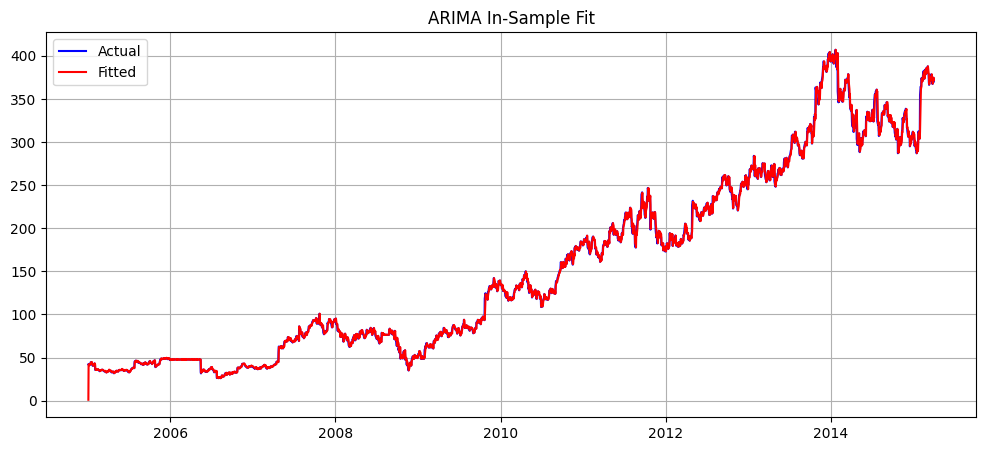

In [107]:
fitted_train = model_fit.fittedvalues

plt.figure(figsize=(12,5))
plt.plot(train_data['Actual_Close'], label='Actual', color = "blue")
plt.plot(fitted_train, label='Fitted', color='red')
plt.title('ARIMA In-Sample Fit')
plt.legend()
plt.grid(True)
plt.show()

#### Performance of model on training data

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [54]:
mse_arima = mean_squared_error(train_data["Actual_Close"], fitted_train)
mse_arima

15.509367515199015

In [55]:
mad_arima = mean_absolute_error(train_data["Actual_Close"], fitted_train)
mad_arima

2.2891298556303448

 With respect to the average value of the train data, the model is producing less error. Hence the model is performing good in the training data.

#### Forecasting test data

In [56]:
n_step = len(test_data)
model_forecast = model_fit.forecast(steps = len(test_data))
forecast = pd.DataFrame(np.array(model_forecast))
forecast.set_index(test_data.index, inplace= True)
forecast.columns = ["Predicated Close"]
forecast["Actual Close"] = test_data["Actual_Close"]
forecast.head()

,Predicated Close,Actual Close
Date,,
2015-04-02,370.231355,372.25
2015-04-03,370.204802,372.25
2015-04-06,370.180313,377.04
2015-04-07,370.157860,374.41
2015-04-08,370.137414,381.20


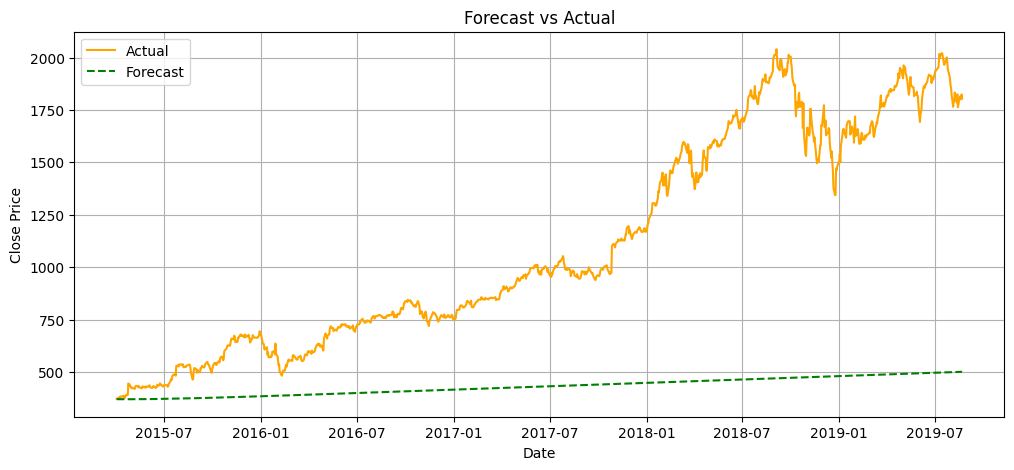

In [57]:

# Optional: create a combined index if needed
forecast_index = test_data.index[:n_step]  # match index with test set

plt.figure(figsize=(12,5))
plt.plot(test_data['Actual_Close'], label='Actual', color='orange')
plt.plot(forecast_index, model_forecast, label='Forecast', color='green', linestyle='--')
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


#### Performance of model in test data

In [116]:
mse_arima_test = mean_squared_error(test_data["Actual_Close"], model_forecast)
np.sqrt(mse_arima_test)

np.float64(816.9982060707465)

In [59]:
mad_arima_test = mean_absolute_error(test_data["Actual_Close"], model_forecast)
mad_arima_test

672.5028770758531

Overall the model performs very poorly in the test data. And the model suffers from overfitting.

#### Residuals

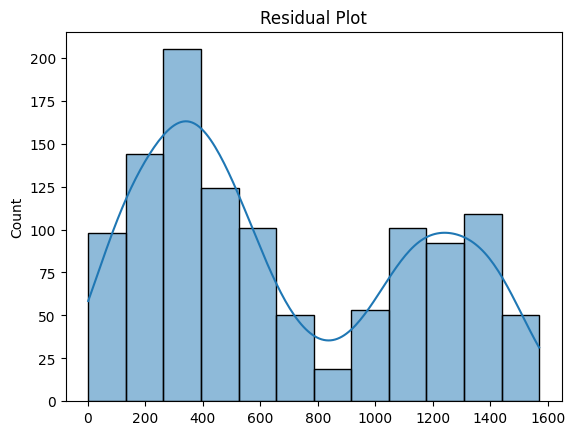

In [60]:
residual_arima = test_data['Actual_Close'] - model_forecast
sns.histplot(residual_arima, kde = True)
plt.title("Residual Plot")
plt.show()

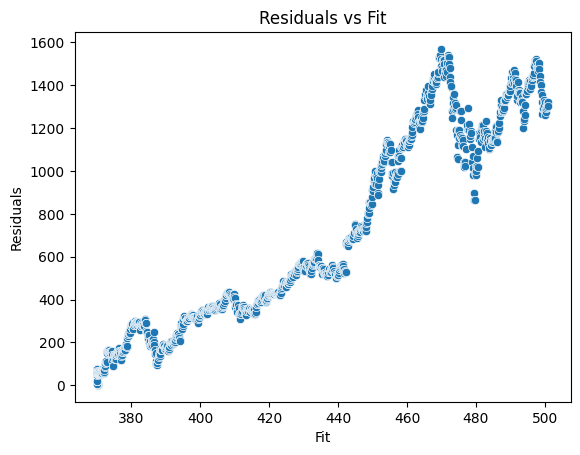

In [61]:
sns.scatterplot(x = model_forecast, y = residual_arima)
plt.ylabel("Residuals")
plt.xlabel("Fit")
plt.title("Residuals vs Fit")
plt.show()

Due to the inaccuracy of the model we now proceed with a new model.

We will try to use ARIMAX model. The our findings suggest that other exogenous factor such as `Google_trends` is affecting the `Close` feature.

### ARIMAX Model

In [118]:
from statsmodels.tsa.arima.model import ARIMA

# Example: ARIMAX(1,1,1)
model = ARIMA(endog=train_data["Actual_Close"], exog=train_data["Google_trends"], order=(1, 1, 2),trend = "t")
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:           Actual_Close   No. Observations:                 2672
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -7392.589
Date:                Sat, 28 Jun 2025   AIC                          14797.177
Time:                        23:10:01   BIC                          14832.519
Sample:                    01-04-2005   HQIC                         14809.965
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
drift             0.1235      0.072      1.716      0.086      -0.018       0.265
Google_trends     0.0112      0.011      1.000      0.317      -0.011       0.033
ar.L1             0.4098      0.278     

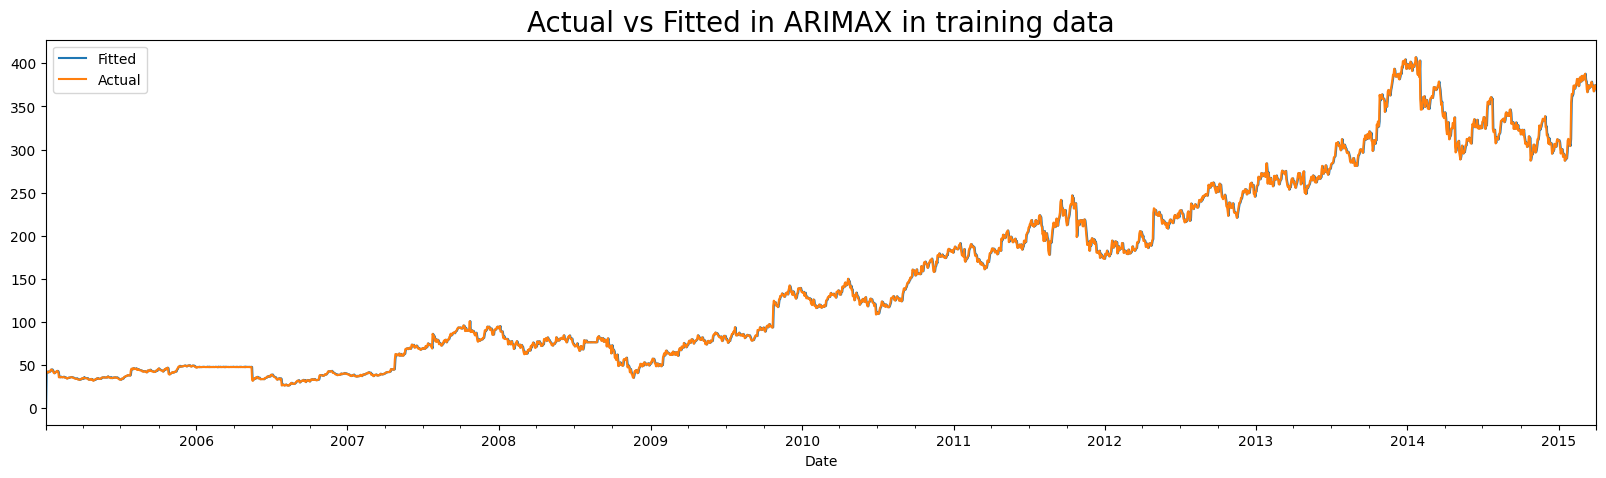

In [149]:
plt.figure(figsize = (20,5))
model_fit.fittedvalues.plot(label = "Fitted")
train_data.Actual_Close.plot(label = "Actual")
plt.title("Actual vs Fitted in ARIMAX in training data", size = 20)
plt.legend()
plt.show()

#### Forecasting test data

In [139]:
forecast = model_fit.forecast(steps=len(test_data.Actual_Close), exog = test_data["Google_trends"])


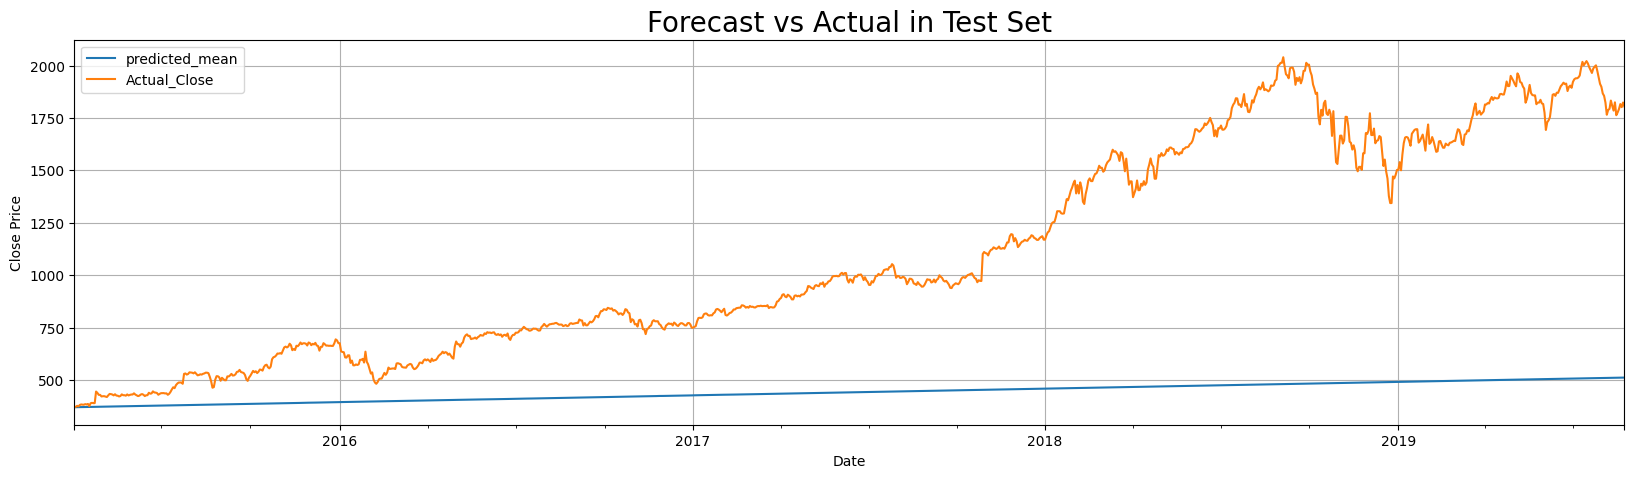

In [126]:
plt.figure(figsize=(20,5))
forecast.plot()
test_data["Actual_Close"].plot()
plt.title('Forecast vs Actual in Test Set', size = 20)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

#### Performance of model in test data

In [127]:
mse_arimax = mean_squared_error(test_data["Actual_Close"], forecast)
np.sqrt(mse_arimax)

np.float64(808.0953852783185)

In [128]:
mad_arimax = mean_absolute_error(test_data["Actual_Close"], forecast)
mad_arimax

662.212448890487

 The accuracy improves with respect to the simple ARIMA model

### Residual

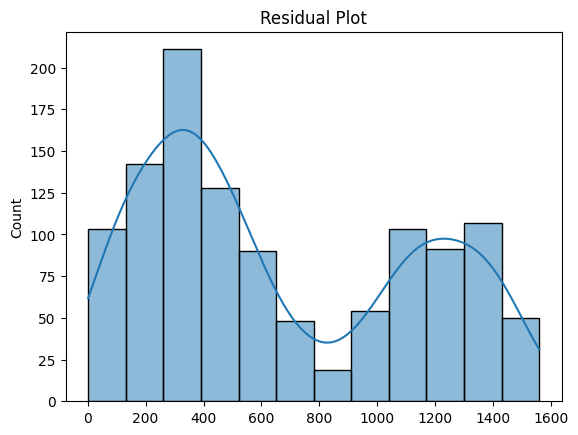

In [140]:
residual_arimax = test_data['Actual_Close'] - forecast
sns.histplot(residual_arimax, kde = True)
plt.title("Residual Plot")
plt.show()

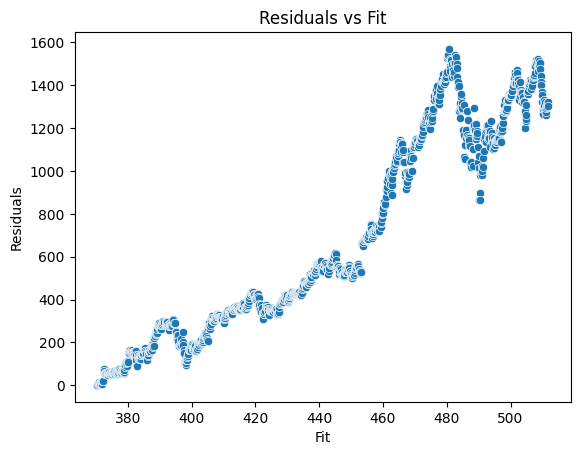

In [142]:
sns.scatterplot(x = forecast, y = residual_arima)
plt.ylabel("Residuals")
plt.xlabel("Fit")
plt.title("Residuals vs Fit")
plt.show()

## Conclusion

In [147]:


# Create a summary DataFrame
metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'ARIMAX'],
    'MSE': [mse_arima_test, mse_arimax],
    'MAD': [mad_arima_test, mad_arimax]
})

metrics_df


,Model,MSE,MAD
0,ARIMA,667486.068723,672.502877
1,ARIMAX,653018.151708,662.212449


As observed, the ARIMAX model produced lower error metrics compared to the ARIMA model. This indicates that including Google Trends as an exogenous variable improves the model's predictive power by capturing additional information beyond historical stock prices.




In this project, we explored the use of classical time series forecasting techniques — ARIMA and ARIMAX — to predict the closing stock prices of Amazon Inc.

The analysis began with preprocessing and differencing the stock price data to achieve stationarity. Autocorrelation (ACF) and partial autocorrelation (PACF) plots were used to guide the selection of appropriate ARIMA parameters. The best ARIMA model was selected based on AIC minimization.

To enhance predictive accuracy, we extended the ARIMA model to ARIMAX by incorporating **Google Trends data** as an exogenous variable. This allowed the model to account for external public interest in Amazon, which may influence investor behavior and market dynamics.

Upon evaluation, the ARIMAX model showed improved forecasting performance over the baseline ARIMA model, suggesting that external sentiment data (like Google Trends) can be a valuable feature in time series forecasting.

---

### 📌 Key Takeaways:
- **ARIMA** provides a solid baseline for univariate time series forecasting.
- **ARIMAX** offers better performance when relevant external predictors are available.
- **Google Trends** can act as a proxy for public/investor interest in a company.

This project demonstrates how combining traditional statistical models with external behavioral data can improve financial forecasting in real-world scenarios.
